<a href="https://colab.research.google.com/github/awildt01/Airbnb_Berlin-/blob/main/notebooks/4_applying_the_PD_Model_for_decision_makingi_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.Scorecards**
In der Praxis übertragen Banken Modelle häufig in sogenannte Scorecards. Diese dienen der strukturierten Aufbereitung der Ergebnisse und fördern die Nachvollziehbarkeit insbesondere für nicht-technische Anspruchsgruppen. Im weiteren Verlauf wird die Umwandlung des Modells in eine Scorecard sowie die darauf basierende Berechnung von Kreditpunkten systematisch erläutert.

## 1.1.Grundidee – Logistische Regression im Kreditmodell

Wir haben ein Kreditrisikomodell mit einer logistischen Regression.  
Das Modell sagt uns: Wie hoch ist die Wahrscheinlichkeit, dass jemand den Kredit zurückzahlt („gut") oder ausfällt („schlecht")?

**Formel:**

$$
P(\text{gut}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n)}}
$$

Alternativ kann sie auch so dargestellt werden:
$$
P(\text{gut}) = \frac{e^{(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n)}}{1 + e^{(\beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_nx_n)}}
$$



Das klingt kompliziert – aber es ist eigentlich nur:  
**Intercept** + **Summe der passenden Dummy-Koeffizienten** → in die Formel einsetzen → **Wahrscheinlichkeit** ausrechnen.

## 1.2.Schritt-für-Schritt mit einem Mini-Beispiel

Stell dir vor, wir haben ein sehr einfaches Modell mit nur 3 Variablen:

*   **Intercept (Basiswert) $\beta_0$**: -1
*   **Kreditrating C $\beta_1$**: +0.7
*   **Hausbesitz Hypothek $\beta_2$**: +0.1
*   **Bundesstaat Kalifornien $\beta_3$**: +0.06

Jetzt haben wir einen Kreditnehmer mit diesen Eigenschaften:

*   Kreditrating = C  ($x_1 = 1$)
*   Hausbesitz = Hypothek  ($x_2 = 1$)
*   Bundesstaat = Kalifornien  ($x_3 = 1$)



### - **Schritt 1: Koeffizienten summieren (Lineare Kombination)**

$$
\beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 = -1 + (0.7 \times 1) + (0.1 \times 1) + (0.06 \times 1) = -0.14
$$

Dieser Wert $(-0.14)$ ist der sogenannte **Logit-Wert** (oder Log-Odds).



### - **Schritt 2: In die Formel einsetzen**

**Exponent berechnen (Odds):**
$$
\text{Odds} = e^{-0.14} \approx 0.87
$$

**Wahrscheinlichkeit berechnen:**
$$
P(\text{gut}) = \frac{0.87}{1 + 0.87} \approx 0.465
$$

Das Modell sagt: **46,5 % Wahrscheinlichkeit**, dass dieser Kreditnehmer den Kredit zurückzahlt.



## 1.3.Warum so viele Summen?

Weil jede Dummy-Variable nur 0 oder 1 ist:

*   Wenn die Eigenschaft **zutrifft** → der entsprechende Koeffizient $\beta_i$ wird addiert.
*   Wenn **nicht** → der Term $\beta_i \times 0$ fällt weg.

**Beispiel:**  
Kreditrating B hat vielleicht den Koeffizienten **+0.3**.  
Wenn jemand **nicht** B ist → Dummy $= 0$ → wir addieren nichts.



## 1.4.Was passiert in der Praxis?

Banken rechnen das nicht jedes Mal manuell, sondern verwandeln das Modell in **Scorecards**:

*   Jede Eigenschaft (z. B. Kreditrating, Hausstatus, Einkommen) bekommt Punkte.
*   Die Punkte werden addiert.
*   Am Ende ergibt sich ein Score (z. B. 650 Punkte).

Ab einem bestimmten Score sagt die Bank: **„Kredit genehmigt"** oder **„abgelehnt"**.

Das ist einfacher als Wahrscheinlichkeiten, weil Punkte leichter zu vergleichen sind.


**Kurz gesagt:**

1.  Wir addieren die passenden Koeffizienten zum **Logit-Wert**.
2.  Rechnen den Exponenten → das sind die **Odds**.
3.  Machen daraus eine **Wahrscheinlichkeit**.
4.  In der Praxis wird das Ganze in eine **Scorecard** umgewandelt.

# **2.Creating a Scorecard**

**1.Erstellen des DataFrame mit Referenzkategorien (df_ref_categories)**


Für die spätere Scorecard-Erstellung wollen wir jede Dummy-Kategorie der im Modell verwendeten Variablen im Scorecard-Tableau abbilden — auch jene Kategorien, die beim Modelltraining als Referenz weggelassen wurden. Da Referenzkategorien beim Fitten keine Koeffizienten haben, fügen wir sie jetzt manuell mit Koeffizient = 0 (und p_value = NaN) ein. So ergibt sich später ein vollständiges, konsistentes Layout mit allen Kategorien pro Original-Feature.

Nach der Schätzung unseres finalen Logit-Modells (Probability of Default Modell) haben wir die Ergebnisse in einer **summary_table** gespeichert.
Diese Tabelle enthält:



- **Feature name**: den Namen der Variable oder Kategorie, die im Modell berücksichtigt wird.

- **Coefficients:** den geschätzten Regressionskoeffizienten (Einfluss auf die Ausfallwahrscheinlichkeit).

     - Positive Werte → senken die Ausfallwahrscheinlichkeit (günstigeres Kreditrisiko).

     - Negative Werte → erhöhen die Ausfallwahrscheinlichkeit (höheres Kreditrisiko).

- **p_values:** Signifikanzwerte, die anzeigen, ob der geschätzte Effekt statistisch relevant ist.

Da für jede kategoriale Variable eine Referenzkategorie festgelegt wird (Baseline), erscheint diese nicht in der **summary_table**.
Beispielsweise wird bei der Variable Grade die Kategorie grade:G als Referenz genutzt – daher finden sich nur die Kategorien grade:A bis grade:F in der Tabelle.



Um auch die Referenzkategorien in unserer finalen Scorecard darzustellen, haben wir die Liste **ref_categories** definiert.
Mit dieser Liste haben wir ein separates DataFrame df_ref_categories erstellt, in dem:

- **Coefficients = 0** (da die Referenz als Vergleichswert dient),

- **p_values = NaN** (nicht berechnet, da Referenz).



Anschließend können wir die **summary_table und df_ref_categories zusammenführen**, sodass eine vollständige Übersicht entsteht, in der alle Kategorien (inkl. Referenzen) enthalten sind.
Diese vollständige Tabelle bildet die Grundlage für die spätere Scorecard-Erstellung.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
import os

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

from google.colab import data_table
data_table.disable_dataframe_formatter()

# unbegrenzte Zeilen und Spalten anzeigen
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [ ]:
# Und hier in der folgenden Liste behalten wir die Variablennamen für die Referenzkategorien bei,
# nur für die Variablen, die wir in unserem endgültigen PD-Modell verwendet haben.
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'delinq_2yrs:0',
'inq_last_6mths:>6',
#'open_acc:0',
#'pub_rec:0-2',
'total_acc:0-15',
#'acc_now_delinq:0',
#'total_rev_hi_lim:<=5K',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [ ]:
# Google Drive mounten
drive.mount('/content/drive')

# Zielordner definieren
folder_path = '/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks'
os.makedirs(folder_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
summary_table = pd.read_csv('/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks/summary_table.csv', index_col = 0,header=0)

In [ ]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-0.233534,NaN
1,grade:A,0.922083,2.245612e-26
2,grade:B,0.685872,1.957918e-30
3,grade:C,0.488966,1.392443e-18
4,grade:D,0.324109,8.033190e-10
5,grade:E,0.189386,5.465670e-05
6,grade:F,0.056816,2.443885e-01
7,home_ownership:OWN,0.083058,1.569663e-05
8,home_ownership:MORTGAGE,0.116799,3.374111e-22
9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,1.999357e-01


In [ ]:
# Vollständige Dezimaldarstellung (kann bei sehr kleinen Werten zu 0.0000 führen)
summary_table['p_values'] = summary_table['p_values'].apply(
    lambda x: f'{x:.6f}' if not pd.isna(x) else 'NaN'
)
# Anzeige der Tabelle
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-0.233534,NaN
1,grade:A,0.922083,0.000000
2,grade:B,0.685872,0.000000
3,grade:C,0.488966,0.000000
4,grade:D,0.324109,0.000000
5,grade:E,0.189386,0.000055
6,grade:F,0.056816,0.244388
7,home_ownership:OWN,0.083058,0.000016
8,home_ownership:MORTGAGE,0.116799,0.000000
9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936


In [ ]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# Wir erstellen einen neuen Datenrahmen mit einer Spalte. Seine Werte sind die Werte aus der Liste „reference_categories“.
# Wir nennen ihn „Featurename“.
df_ref_categories['Coefficients'] = 0
# Fügt eine Spalte Coefficients hinzu und füllt sie mit 0. Warum 0?
# Weil beim Modelltraining keine Koeffizienten für Referenzen geschätzt wurden
# — ihre impliziten Koeffizienten sind 0 (die Referenz ist die Vergleichsbasis).
df_ref_categories['p_values'] = np.nan
# → Fügt eine Spalte p_values mit NaN ein, weil für diese (künstlich hinzugefügten) Zeilen keine statistischen Tests bzw. p-Werte berechnet wurden.
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [ ]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates zwei dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-0.233534,NaN
1,1,grade:A,0.922083,0.000000
2,2,grade:B,0.685872,0.000000
3,3,grade:C,0.488966,0.000000
4,4,grade:D,0.324109,0.000000
5,5,grade:E,0.189386,0.000055
6,6,grade:F,0.056816,0.244388
7,7,home_ownership:OWN,0.083058,0.000016
8,8,home_ownership:MORTGAGE,0.116799,0.000000
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936


In [ ]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
# Wir erstellen eine neue Spalte mit dem Namen „Original Feature name“,
# die den Wert der Spalte „Feature name“ bis zum Spaltensymbol enthält.

In [ ]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-0.233534,NaN,Intercept
1,1,grade:A,0.922083,0.000000,grade
2,2,grade:B,0.685872,0.000000,grade
3,3,grade:C,0.488966,0.000000,grade
4,4,grade:D,0.324109,0.000000,grade
5,5,grade:E,0.189386,0.000055,grade
6,6,grade:F,0.056816,0.244388,grade
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state


## **2.1.Score**
- Wenn wir für jede Variable die schlechteste Ausprägung nehmen und diese summieren, erhalten wir das niedrigste mögliche Modell-Logit-Ergebnis.

- Dieses Ergebnis wird später auf die Score-Skala (z. B. 300–850) transformiert.

- So stellen wir sicher, dass die Kombination „schlechteste Kategorie bei allen Variablen“ tatsächlich den Minimalwert der Skala (hier 300) ergibt.

- Mit .max() bestimmen wir die beste Ausprägung pro Variable.

- Wenn wir diese summieren, erhalten wir den theoretisch höchsten Score, der dann auf 850 gemappt wird.

In [ ]:
min_score = 300
max_score = 850

In [ ]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Minimum.

,Coefficients
Original feature name,
Intercept,-0.233534
addr_state,-0.017217
annual_inc,-0.157414
delinq_2yrs,-0.117282
dti,-0.116832
emp_length,0.000000
grade,0.000000
home_ownership,0.000000
initial_list_status,0.000000


In [ ]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Bis zur Methode „min()“ ist alles wie in der obigen Zeile.
# Anschließend aggregieren wir weiter und summieren alle Minimalwerte.
min_sum_coef

np.float64(-0.9028357194654884)

In [ ]:
df_scorecard.groupby('Original feature name')['Coefficients'].max()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Maximum.

,Coefficients
Original feature name,
Intercept,-0.233534
addr_state,0.632358
annual_inc,0.460002
delinq_2yrs,0.000000
dti,0.214882
emp_length,0.118364
grade,0.922083
home_ownership,0.116799
initial_list_status,0.039322


In [ ]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Bis zur Methode „min()“ ist alles wie in der Zeile oben.
# Anschließend aggregieren wir weiter und summieren alle Maximalwerte.
max_sum_coef

np.float64(5.407542809776595)

## **2.2.Lineare Transformation der Koeffizienten**

Damit die Modellkoeffizienten in einen Scorebereich (z. B. 300–850 Punkte) übersetzt werden können, wendet man eine lineare Transformation an.

**Bedeutung der einzelnen Teile**

- df_scorecard['Coefficients']
→ Das sind die β-Werte aus dem logistischen Modell.
Beispiel: Für "grade:A" = 0.92.

- (max_score - min_score)
→ Das ist der Zielbereich der Scorecard.
Beispiel: 850 – 300 = 550 Punkte.

- (max_sum_coef - min_sum_coef)
→ Das ist der Spannungsbereich der Modellkoeffizienten.

- max_sum_coef: maximale mögliche Summe der β-Werte (wenn eine Person in allen "besten Kategorien" ist).

- min_sum_coef: minimale mögliche Summe der β-Werte (wenn eine Person in allen "schlechtesten Kategorien" ist).

Damit haben wir die „Spanne“ der Logit-Skala.

**Multiplikation:**

→ Wir skalieren die einzelnen β-Werte so, dass sie in das gewünschte Punktesystem passen.

**Interpretierbarkeit:**

- Statt mit Logits zu hantieren, bekommt man eine verständliche Punkteskala (wie bei Schufa oder FICO).

- Vergleichbarkeit: Jeder Koeffizient trägt eine bestimmte Anzahl an Punkten zum Gesamtscore bei.

**Praxisnutzen: Kreditgeber können sagen:**

- "Ein Score von 700 bedeutet mittleres Risiko."

- "Ein Kunde mit 850 ist super, einer mit 300 sehr riskant."

## 2.3.Lineare Skalierung (ohne Verschiebung)
-  Wir skalieren die Roh-Koeffizienten proportional auf den Punktbereich (300–850).
- Ergebnis: Jede Ausprägung einer Variable bekommt Punkte zugewiesen.

Beispiel:

  - Einkommen hoch → +80 Punkte
 - Schulden hoch → –50 Punkte
 - Damit können wir die Einflüsse der Variablen interpretieren.

In [ ]:
# Wir skalieren die Roh-Koeffizienten proportional auf den Punktbereich (300–850).
# Ergebnis: Jede Ausprägung einer Variable bekommt Punkte zugewiesen.
# Beispiel:
# Einkommen hoch → +80 Punkte
# Schulden hoch → –50 Punkte
# Damit können wir die Einflüsse der Variablen interpretieren.
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
# Wir multiplizieren den Wert der Spalte „Koeffizienten“ mit dem Verhältnis der Differenzen zwischen
# Maximalpunktzahl und Minimalpunktzahl sowie der maximalen Summe der Koeffizienten und der minimalen Summe der Koeffizienten.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.233534,NaN,Intercept,-20.354359
1,1,grade:A,0.922083,0.000000,grade,80.366875
2,2,grade:B,0.685872,0.000000,grade,59.779210
3,3,grade:C,0.488966,0.000000,grade,42.617335
4,4,grade:D,0.324109,0.000000,grade,28.248711
5,5,grade:E,0.189386,0.000055,grade,16.506545
6,6,grade:F,0.056816,0.244388,grade,4.951947
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634


## 2.4.Normalisierung des Gesamtscores

Hier normalisieren wir den Wert so, dass der **Gesamtscore eines Kunden** immer zwischen **{min\_score} = 300\) und \({max\_score} = 850\)** liegt.

Formel = klassische **Min-Max-Normierung**:

$$
Score = \frac{Wert - \text{Min}}{\text{Max} - \text{Min}} \times (850 - 300) + 300
$$

Dadurch stellen wir sicher:

- Der **schlechteste Kunde** hat genau **300 Punkte**.  
- Der **beste Kunde** hat genau **850 Punkte**.



In [ ]:
# Wir dividieren die Differenz zwischen dem Wert in der Spalte „Koeffizienten“ und der minimalen Summe der Koeffizienten durch
# die Differenz zwischen der maximalen und der minimalen Summe der Koeffizienten.
# Anschließend multiplizieren wir das Ergebnis mit der Differenz zwischen der maximalen und der minimalen Punktzahl.
# Anschließend addieren wir die minimale Punktzahl.
df_scorecard.loc[0, 'Score - Calculation'] = (
    (df_scorecard.loc[0, 'Coefficients'] - min_sum_coef)
    / (max_sum_coef - min_sum_coef)
) * (max_score - min_score) + min_score

df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.233534,NaN,Intercept,358.335001
1,1,grade:A,0.922083,0.000000,grade,80.366875
2,2,grade:B,0.685872,0.000000,grade,59.779210
3,3,grade:C,0.488966,0.000000,grade,42.617335
4,4,grade:D,0.324109,0.000000,grade,28.248711
5,5,grade:E,0.189386,0.000055,grade,16.506545
6,6,grade:F,0.056816,0.244388,grade,4.951947
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634


In [ ]:
#df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
# We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by
# the difference of the maximum sum of coefficients and the minimum sum of coefficients.
# Then, we multiply that by the difference between the maximum score and the minimum score.
# Then, we add minimum score.
#df_scorecard

In [ ]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# Wir runden die Werte der Spalte „Score – Berechnung“.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-0.233534,NaN,Intercept,358.335001,358.0
1,1,grade:A,0.922083,0.000000,grade,80.366875,80.0
2,2,grade:B,0.685872,0.000000,grade,59.779210,60.0
3,3,grade:C,0.488966,0.000000,grade,42.617335,43.0
4,4,grade:D,0.324109,0.000000,grade,28.248711,28.0
5,5,grade:E,0.189386,0.000055,grade,16.506545,17.0
6,6,grade:F,0.056816,0.244388,grade,4.951947,5.0
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135,7.0
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993,10.0
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634,-2.0


In [ ]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Minimum.
# Summiert alle Minimumwerte.
min_sum_score_prel

np.float64(301.0)

In [ ]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Maximum.
# Summiert alle Maximalwerte.
max_sum_score_prel

np.float64(848.0)

In [ ]:
# Von der Maximalpunktzahl einer ursprünglichen Variable muss ein Wert abgezogen werden. Welcher? Wir bewerten anhand der Unterschiede.

In [ ]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-0.233534,NaN,Intercept,358.335001,358.0,-0.335001
1,1,grade:A,0.922083,0.000000,grade,80.366875,80.0,-0.366875
2,2,grade:B,0.685872,0.000000,grade,59.779210,60.0,0.220790
3,3,grade:C,0.488966,0.000000,grade,42.617335,43.0,0.382665
4,4,grade:D,0.324109,0.000000,grade,28.248711,28.0,-0.248711
5,5,grade:E,0.189386,0.000055,grade,16.506545,17.0,0.493455
6,6,grade:F,0.056816,0.244388,grade,4.951947,5.0,0.048053
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135,7.0,-0.239135
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993,10.0,-0.179993
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634,-2.0,-0.499366


In [ ]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']

df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-0.233534,NaN,Intercept,358.335001,358.0,-0.335001,358.0
1,1,grade:A,0.922083,0.000000,grade,80.366875,80.0,-0.366875,80.0
2,2,grade:B,0.685872,0.000000,grade,59.779210,60.0,0.220790,60.0
3,3,grade:C,0.488966,0.000000,grade,42.617335,43.0,0.382665,43.0
4,4,grade:D,0.324109,0.000000,grade,28.248711,28.0,-0.248711,28.0
5,5,grade:E,0.189386,0.000055,grade,16.506545,17.0,0.493455,17.0
6,6,grade:F,0.056816,0.244388,grade,4.951947,5.0,0.048053,5.0
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135,7.0,-0.239135,7.0
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993,10.0,-0.179993,10.0
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634,-2.0,-0.499366,-2.0


In [ ]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Minimum.
# Summiert alle Minimumwerte.
min_sum_score_prel

np.float64(301.0)

In [ ]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
# Gruppiert die Daten nach den Werten der Spalte „Ursprünglicher Merkmalsname“.
# Aggregiert die Daten in der Spalte „Koeffizienten“ und berechnet deren Maximum.
# Summiert alle Maximalwerte.
max_sum_score_prel

np.float64(848.0)

## **2.5.Finales Scorecard**

Wir müssen zweimal prüfen:

- Min-Score: darf nicht größer als 300 werden.
→ also nichts bei den minimalen Kategorien anfassen.

- Max-Score: muss von 847 auf 850.
→ also 3 Punkte hinzufügen, nicht abziehen.

Das heißt: wir suchen die Features, die den maximalen Score bilden, und dort erhöhen wir die Kategorie, die am stärksten durch Rundung „verloren“ hat.

In [ ]:
# 1. Differenz zwischen gerundetem und originalem Score
df_scorecard["diff_rounding"] = df_scorecard["Score - Preliminary"] - df_scorecard["Score - Calculation"]

# 2. Kategorien identifizieren, die beim Maximum beteiligt sind
max_features = df_scorecard.groupby("Original feature name")["Score - Final"].idxmax()
df_max_features = df_scorecard.loc[max_features]

# 3. Kandidaten für Korrektur → die, die am meisten nach unten gerundet wurden
idx_to_fix = df_max_features["diff_rounding"].idxmin()  # hier: minimalster Wert = größte negative Rundung

# 4. Dort 3 Punkte addieren, um 847 → 850 zu heben
df_scorecard.loc[idx_to_fix, "Score - Final"] += 2

# 5. Nochmal prüfen
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()

print("Min:", min_sum_score_prel, "Max:", max_sum_score_prel)


Min: 301.0 Max: 850.0


In [ ]:
# 1. Kategorien für Minimum ermitteln
min_features = df_scorecard.groupby("Original feature name")["Score - Final"].idxmin()
df_min_features = df_scorecard.loc[min_features]

# 2. Kandidat mit größter positive Rundungsabweichung suchen
idx_to_fix_min = df_min_features["diff_rounding"].idxmax()

# 3. Dort 1 Punkt abziehen
df_scorecard.loc[idx_to_fix_min, "Score - Final"] -= 1

# 4. Nochmal prüfen
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()

print("Min:", min_sum_score_prel, "Max:", max_sum_score_prel)


Min: 300.0 Max: 850.0


In [ ]:
# # -Scorecard Final Adjustment (Min = 300, Max = 850) ----

# # Rundungsdifferenz berechnen (Preliminary - Calculation)
# df_scorecard["diff_rounding"] = df_scorecard["Score - Preliminary"] - df_scorecard["Score - Calculation"]

# # Start: Score - Final = Score - Preliminary
# df_scorecard["Score - Final"] = df_scorecard["Score - Preliminary"]

# # 1. Maximalen Score prüfen
# max_features = df_scorecard.groupby("Original feature name")["Score - Final"].idxmax()
# df_max_features = df_scorecard.loc[max_features]

# if df_max_features["Score - Final"].sum() > 850:
#     # Index der am stärksten "nach oben gerundeten" Kategorie finden
#     idx_to_fix_max = df_max_features["diff_rounding"].idxmax()
#     # 1 Punkt abziehen
#     df_scorecard.loc[idx_to_fix_max, "Score - Final"] -= 1

# # 2. Minimalen Score prüfen
# min_features = df_scorecard.groupby("Original feature name")["Score - Final"].idxmin()
# df_min_features = df_scorecard.loc[min_features]

# if df_min_features["Score - Final"].sum() > 300:
#     # Index der am stärksten "nach oben gerundeten" Kategorie finden
#     idx_to_fix_min = df_min_features["diff_rounding"].idxmax()
#     # 1 Punkt abziehen
#     df_scorecard.loc[idx_to_fix_min, "Score - Final"] -= 1

# # 3. Kontrolle: Min/Max Summen neu berechnen
# min_sum_score_prel = df_scorecard.groupby('Original feature name')["Score - Final"].min().sum()
# max_sum_score_prel = df_scorecard.groupby('Original feature name')["Score - Final"].max().sum()

# print("✅ Final Check - Min:", min_sum_score_prel, "Max:", max_sum_score_prel)


**Finales Scorecard**
- Ergebnis: Score - Final mit ganzzahligen Punkten für jede Dummy-Kategorie,  validiert so dass min = min_score und max = max_score.

# 3.Caclulating Credit Score (Berechnung des Kreditscores)

## 3.1.Grundidee

Das **Ziel** dieses Abschnitts ist es, den Kredit-Score jedes Kreditnehmers im Testdatensatz zu berechnen.
Der Score basiert auf den geschätzten Modellkoeffizienten aus dem PD-Modell (Probability of Default Model).
So kann für jede Person ein numerischer Wert zwischen 300 (schlechteste Bonität) und 850 (beste Bonität) ermittelt werden.



Das Prinzip ist dasselbe wie bei der logistischen Regression:  
- Jeder Kreditnehmer erhält Punkte (Scores) basierend auf den **Merkmalskategorien**, zu denen er gehört  
(z. B. Bonitätsklasse, Einkommen, Wohnstatus usw.).  
- Jeder Faktor trägt **positiv oder negativ** zum Gesamtscore bei.

<br />
<br />
<br />

|                   Schritt                   | Beschreibung                                                                                                   |
| :-----------------------------------------: | :------------------------------------------------------------------------------------------------------------- |
|    **1. Dummy-Variablen identifizieren**    | Für jede kategoriale Variable wird nur eine Dummy-Variable aktiv (Wert = 1), alle anderen = 0.                 |
|   **2. Scores aus der Scorecard zuordnen**  | Jedem Dummy (z. B. „Home = Mortgage“) wird der passende Punktwert aus der Scorecard zugewiesen.                |
|      **3. Intercept-Spalte hinzufügen**     | Eine Spalte mit lauter Einsen wird ergänzt, damit der Basiswert (Intercept) in die Berechnung eingeht.         |
|     **4. Spaltenreihenfolge angleichen**    | Die Spalten im Test-Datensatz werden so sortiert, dass sie exakt der Reihenfolge in der Scorecard entsprechen. |
|        **5. Score-Vektor erstellen**        | Aus der Scorecard wird ein Vektor mit allen Punktwerten (( w_i )) in derselben Reihenfolge erstellt.           |
|   **6. Matrixmultiplikation durchführen**   | Jede Zeile (eine Person) wird mit dem Score-Vektor multipliziert → dies entspricht einem **Skalarprodukt**.    |
| **7. Ergebnis = individueller Kreditscore** | Die Summe ergibt den individuellen Gesamtscore einer Person.

<br />

**Ergebnis:**

Der berechnete Score jedes Kunden liegt zwischen 300 und 850.

Damit können Kreditnehmer nach Risikoprofil eingestuft werden.

Beispiel:

- Score = 850 → sehr gute Bonität (niedriges Ausfallrisiko)

- Score = 300 → schlechte Bonität (hohes Ausfallrisiko)





## 3.2.Zusammenhang mit dem PD-Modell

- **In diesem Abschnitt berechnen wir den individuellen Kreditscore eines Kreditnehmers**.

Das PD-Modell (Probability of Default) wurde mit **Dummy-Variablen** trainiert.  
Das bedeutet:

- Für jede Kategorie einer Variable (z. B. `grade:A`, `grade:B`, `grade:C`) gibt es eine eigene Spalte.  
- Eine Spalte hat den Wert **1**, wenn der Kreditnehmer zu dieser Kategorie gehört, sonst **0**.

Beispiel:

| grade:A | grade:B | grade:C |
|----------|----------|----------|
| 0 | 1 | 0 |

Dieser Kreditnehmer gehört also zur Kategorie **B**.

Die zugehörigen **Koeffizienten (Gewichte)** stammen aus dem trainierten Modell.

## 3.3.Vom Modell zum Score

Jeder Kreditnehmer gehört genau zu **einer Dummy-Kategorie** pro Merkmal.  
Daher ergibt sich der Gesamtscore als:

$ \text{Gesamtscore} = \sum_{i=1}^{n} \text{Score}_i $

Das ist dieselbe Logik wie bei der Berechnung des Log-Odds,  
nur dass wir hier Punkte im Bereich **300 – 850** berechnen.

## 3.4.Beispiel für einen Kreditnehmer

Wir betrachten den Kreditnehmer mit **Index 362514**.

| Schritt | Merkmal | Kategorie | Score | Zwischensumme |
|----------|----------|------------|--------|----------------|
| 1 | Intercept | – | 312 | 312 |
| 2 | grade | C | +53 | 365 |
| 3 | home_ownership | MORTGAGE | +8 | 373 |
| 4 | addr_state | CA | +5 | 378 |
| … | … | … | … | … |
| ✅ | **Gesamt** |  |  | **608 Punkte** |

- Ergebnis: **608 Punkte** sind der Gesamtscore dieses Kreditnehmers.

## 3.5.Berechnung für alle Kreditnehmer

Jetzt berechnen wir die Scores für **alle Beobachtungen** aus dem Testdatensatz.  
Im DataFrame `inputs_test_with_ref_cat` befinden sich alle Dummy-Variablen (1/0) für jedes Merkmal.

In [ ]:
# Google Drive mounten
drive.mount('/content/drive')

# Zielordner definieren
folder_path = '/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks'
os.makedirs(folder_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
inputs_test_with_ref_cat = pd.read_csv('/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks/inputs_test_with_ref_cat.csv', index_col = 0,header=0)

In [ ]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:OK_LA_NC_NM_MO_VA_NJ,addr_state:MD_TN_AZ_PA_MI,addr_state:DE_AR,addr_state:UT_MN_OH_IN_GA_ RI_WA,addr_state:OR_KY_MA,addr_state:MT_MS_SD,addr_state:WI_IL_CT_AK,addr_state:CO_SC,addr_state:KS_NH_WV_VT_ID,addr_state:WY_DC_ME,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,delinq_2yrs:0,delinq_2yrs:1-3,delinq_2yrs:4-16,delinq_2yrs:>=17,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,total_acc:0-15,total_acc:16-70,total_acc:71-90,total_acc:>90,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
288564,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
213591,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
263083,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
165001,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final,diff_rounding
0,0,Intercept,-0.233534,NaN,Intercept,358.335001,358.0,-0.335001,358.0,-0.335001
1,1,grade:A,0.922083,0.000000,grade,80.366875,80.0,-0.366875,80.0,-0.366875
2,2,grade:B,0.685872,0.000000,grade,59.779210,60.0,0.220790,60.0,0.220790
3,3,grade:C,0.488966,0.000000,grade,42.617335,43.0,0.382665,43.0,0.382665
4,4,grade:D,0.324109,0.000000,grade,28.248711,28.0,-0.248711,28.0,-0.248711
5,5,grade:E,0.189386,0.000055,grade,16.506545,17.0,0.493455,17.0,0.493455
6,6,grade:F,0.056816,0.244388,grade,4.951947,5.0,0.048053,5.0,0.048053
7,7,home_ownership:OWN,0.083058,0.000016,home_ownership,7.239135,7.0,-0.239135,7.0,-0.239135
8,8,home_ownership:MORTGAGE,0.116799,0.000000,home_ownership,10.179993,10.0,-0.179993,10.0,-0.179993
9,9,addr_state:OK_LA_NC_NM_MO_VA_NJ,-0.017217,0.199936,addr_state,-1.500634,-2.0,-0.499366,-2.0,-0.499366


## 3.6.Vorbereitung für die Score-Berechnung

Wir haben bereits:

- Die Koeffizienten (oder Scores) in `df_scorecard`

- Die Dummy-Variablen in `inputs_test_with_ref_cat`

Um alle Scores zu berechnen, brauchen wir nur:

\[
$ \text{Score} = \text{Datenmatrix} \times \text{Score-Vektor} $
\]

Aber zuerst müssen wir sicherstellen, dass:

- Die Spalten der Testdaten in derselben Reihenfolge stehen wie die Variablen in der Scorecard.

- Der Intercept (Basispunkte) auch berücksichtigt wird.

## 3.7.Hinzufügen des Intercepts

Da der Intercept kein eigenes Merkmal hat (es gibt keine Dummy-Spalte dafür),
fügen wir manuell eine Spalte mit lauter 1en hinzu.

inputs_test_with_ref_cat.insert(0, 'Intercept', 1)


- 0 → Spalte wird an erster Stelle eingefügt.

- 'Intercept' → Spaltenname.

- 1 → Wert in jeder Zeile.





In [ ]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [ ]:
inputs_test_with_ref_cat_w_intercept.insert(0, 'Intercept', 1)
# Wir fügen eine Spalte mit dem Index 0 in den Datenrahmen ein, also am Anfang des Datenrahmens.
# Der Name dieser Spalte lautet „Intercept“ und ihre Werte sind 1.

In [ ]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:OK_LA_NC_NM_MO_VA_NJ,addr_state:MD_TN_AZ_PA_MI,addr_state:DE_AR,addr_state:UT_MN_OH_IN_GA_ RI_WA,addr_state:OR_KY_MA,addr_state:MT_MS_SD,addr_state:WI_IL_CT_AK,addr_state:CO_SC,addr_state:KS_NH_WV_VT_ID,addr_state:WY_DC_ME,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,delinq_2yrs:0,delinq_2yrs:1-3,delinq_2yrs:4-16,delinq_2yrs:>=17,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,total_acc:0-15,total_acc:16-70,total_acc:71-90,total_acc:>90,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
362514,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
288564,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
213591,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
263083,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
165001,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## 3.8.Gleiche Spaltenreihenfolge

- Jetzt müssen die Spalten im Test-DataFrame in der gleichen Reihenfolge stehen wie die Feature name-Spalte in der df_scorecard.

- inputs_test_with_ref_cat = inputs_test_with_ref_cat[df_scorecard['Feature name']]


- Damit stimmt die Reihenfolge exakt überein → wichtig für Matrixmultiplikation!



In [ ]:
scorecard_scores = df_scorecard['Score - Final']

scorecard_scores.head()

,Score - Final
0,358.0
1,80.0
2,60.0
3,43.0
4,28.0


In [ ]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard['Feature name'].values]
# Hier behalten wir aus dem Dataframe „inputs_test_with_ref_cat_w_intercept“ nur die Spalten mit Spaltennamen bei,
# die genau den Zeilenwerten der Spalte „Feature name“ aus dem Dataframe „df_scorecard“ entsprechen.

## 3.9.Score-Vektor vorbereiten

Wir speichern alle Scores (aus der Scorecard) in einem Vektor:

- scorecard_scores = df_scorecard['Score - Final'].values.reshape(-1, 1)


- .values → Numpy-Array.reshape(-1, 1) → macht aus einem Vektor (z. B. [102,]) eine Spaltenmatrix (102×1)
→ nötig, um sie mit der Testdatenmatrix zu multiplizieren.

In [ ]:
inputs_test_with_ref_cat_w_intercept.shape

(93257, 104)

In [ ]:
scorecard_scores.shape

(104,)

In [ ]:
scorecard_scores = scorecard_scores.values.reshape(104, 1)

In [ ]:
scorecard_scores.shape

(104, 1)

## 3.10.Matrixmultiplikation = Gesamtscore

Jetzt multiplizieren wir jede Zeile (ein Kreditnehmer) mit dem Score-Vektor:

test_scores = inputs_test_with_ref_cat.dot(scorecard_scores)


- Das ist die sogenannte Punktprodukt-Operation (dot product) aus der linearen Algebra:

- Jede Zeile × Gewichte = individueller Score.

$$
Score_j = \sum_{i=1}^{n} x_{ji} \cdot w_i
$$

**Legende:**

- $Score_j$: Gesamtscore der Person $j$  
- $x_{ji}$: Wert der $i$-ten Eingangsvariablen (1 oder 0)  
- $w_i$: Gewicht bzw. Punktwert aus der Scorecard  
- $n$: Anzahl der Variablen

In [ ]:
y_scores = inputs_test_with_ref_cat_w_intercept.dot(scorecard_scores)
# Hier multiplizieren wir die Werte jeder Zeile des Datenrahmens mit den Werten jeder Spalte der Variable,
# die ein Argument der „dot“-Methode ist, und summieren sie. Es ist im Wesentlichen die Summe der Produkte

In [ ]:
y_scores.head()

,0
362514,671.0
288564,539.0
213591,656.0
263083,517.0
165001,553.0


In [ ]:
y_scores.tail()

,0
115,554.0
296284,688.0
61777,481.0
91763,571.0
167512,500.0


## 3.11.From credit score to PD

Dieser Code macht die Umkehrung der Scorecard-Transformation - von den praktischen Scores zurück zu den ursprünglichen Wahrscheinlichkeiten!

Das ist besonders nützlich um:

- Scores für Kunden zu interpretieren ("Score 650 = 74.8% Rückzahlungswahrscheinlichkeit")

- Die Genauigkeit der Scorecard zu validieren

- Mit anderen Systemen zu kommunizieren, die mit Wahrscheinlichkeiten arbeiten


✅ Validierung: Prüft ob Score-Berechnung korrekt war

✅ Interpretation: Macht Scores wieder als Wahrscheinlichkeit verständlich

✅ Flexibilität: Ermöglicht Arbeit mit beiden Darstellungen

## 3.12.Threshold-Analyse (0.80)

**Threshold = 0.80** bedeutet:
> Nur Kunden mit einer vorhergesagten Wahrscheinlichkeit von mindestens 80 %, den Kredit zurückzuzahlen, werden als „gut“ eingestuft.

### Modellwerte:
- **True Positive Rate (TPR)** = 0.65  
- **False Positive Rate (FPR)** = 0.10  

### Angenommene Verteilung:
- Gesamt: 1000 Kreditanträge  
- Tatsächlich gut: 800  
- Tatsächlich schlecht: 200  

### Berechnungen:
| Kennzahl | Formel | Ergebnis | Bedeutung |
|-----------|---------|-----------|------------|
| **TP** | 0.65 × 800 | 520 | Gute Kunden korrekt erkannt |
| **FN** | 800 − 520 | 280 | Gute Kunden abgelehnt |
| **FP** | 0.10 × 200 | 20 | Schlechte Kunden fälschlich genehmigt |
| **TN** | 200 − 20 | 180 | Schlechte Kunden korrekt abgelehnt |

### Konfusionsmatrix

|                      | **Tatsächlich gut** | **Tatsächlich schlecht** |
|----------------------|---------------------|---------------------------|
| **Vorhergesagt = gut** | TP = 520 | FP = 20 |
| **Vorhergesagt = schlecht** | FN = 280 | TN = 180 |

### Ergebnisse:
- **Genehmigungsrate:** \( \frac{520 + 20}{1000} = 54\% \)
- **Ausfallrate unter Genehmigten:** \( \frac{20}{540} = 3.7\% \)

###  Interpretation:
Der Threshold von **0.80** ist **ausgewogen**:
- Die Bank genehmigt rund **54 %** der Anträge.
- Die **Ausfallrate** bleibt mit **3.7 %** niedrig.
- Ein höherer Threshold = sicherer, aber restriktiver.  
- Ein niedrigerer Threshold = mehr Genehmigungen, aber höheres Risiko.


Schritt 1: Von Score zurück zu Koeffizientensumme (LogOdds)

**Das ist die UMKEHRUNG der Score-Berechnung:**

- LogOdds = ((Score - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef

- Score = Offset + Faktor × LogOdds

**Aufgegliedert:**

- Faktor = (max_score - min_score) / (max_sum_coef - min_sum_coef)

  
- Offset = min_score - (Faktor * min_sum_coef)

**Vorwärts-Transformation: LogOdds → Score**
- Score = Offset + Faktor × LogOdds

- LogOdds = (Score - Offset) / Faktor


**Aufgegliedert:**

- (y_scores - min_score) = Wie weit vom Minimum entfernt?

- / (max_score - min_score) = Normalisierung auf 0-1

- '*' (max_sum_coef - min_sum_coef) = Skalierung auf Koeffizienten-Bereich

- '+' min_sum_coef = Verschiebung zum richtigen Startpunkt

In [ ]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
# Wir dividieren die Differenz zwischen den Punktzahlen und der Mindestpunktzahl durch
# die Differenz zwischen der Höchstpunktzahl und der Mindestpunktzahl.
# Anschließend multiplizieren wir das Ergebnis mit der Differenz zwischen der maximalen und der minimalen Summe der Koeffizienten.
# Anschließend addieren wir die minimale Summe der Koeffizienten.

**Das ist die Standard-Logistic-Function:**

- P(gut) = e^(LogOdds) / (1 + e^(LogOdds))

In [ ]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head()

,0
362514,0.966229
288564,0.862867
213591,0.960140
263083,0.830179
165001,0.880791


In [ ]:
# Google Drive mounten
drive.mount('/content/drive')

# Zielordner definieren
folder_path = '/content/drive/MyDrive/Lending-Club-Credit-Scoring/notebooks'
os.makedirs(folder_path, exist_ok=True)  # Ordner erstellen, falls nicht vorhanden

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. numpy Array wieder laden
y_hat_test_proba = np.load(f'{folder_path}/y_hat_test_proba.npy')
print("numpy Array erfolgreich geladen!")

# 2. DataFrame wieder laden
df_actual_predicted_probs = pd.read_csv(f'{folder_path}/df_actual_predicted_probs.csv')
print("DataFrame erfolgreich geladen!")

# Vergleich der geladenen Daten
#print(f"Original Shape: {y_hat_test_proba.shape}")
print(f"Geladen Shape: {y_hat_test_proba.shape}")
#print(f"Sind gleich: {np.array_equal(y_hat_test_proba, y_hat_test_proba_loaded)}")

numpy Array erfolgreich geladen!
DataFrame erfolgreich geladen!
Geladen Shape: (93257,)


In [ ]:
df_actual_predicted_probs['y_hat_test_proba'].head()

,y_hat_test_proba
0,0.966109
1,0.862006
2,0.959206
3,0.829106
4,0.878325


In [ ]:
y_hat_test_proba[0: 5]

array([0.96610933, 0.86200583, 0.95920603, 0.82910638, 0.8783246 ])

In [ ]:
y_hat_proba_from_score.head()

,0
362514,0.966229
288564,0.862867
213591,0.960140
263083,0.830179
165001,0.880791


## 3.13.Setting Cut-offs

### 1.Analyse bei Threshold = 0.8

Wir analysieren nur die Kunden, bei denen das Modell eine vorhergesagte Wahrscheinlichkeit
von mindestens **0.8** für "guter Kreditnehmer" liefert.

- Kunden mit $( P(\text{gut}) \ge 0.8 $) werden **als gut klassifiziert**.
- Kunden mit $( P(\text{gut}) < 0.8 \$) werden **als schlecht klassifiziert**.

Bei diesem Threshold ergeben sich folgende Kennzahlen:

- **True Positive Rate (TPR) = 0.65**  
  → 65 % der tatsächlich guten Kunden werden korrekt erkannt.  
- **False Positive Rate (FPR) = 0.10**  
  → 10 % der tatsächlich schlechten Kunden werden fälschlicherweise als gut eingestuft.

Diese Werte zeigen, dass das Modell bei einem hohen Threshold sehr vorsichtig ist:
- Nur sehr sichere Kunden werden genehmigt.
- Das Risiko für Kreditausfälle bleibt gering.



**Trade-Off in der Praxis**


**Bank mit hohem Cut-Off (700 Punkte):**

- Sehr geringe Ausfallrate (1-2%)

- Wenige Kreditkunden (nur 30% werden genehmigt)

- Geringeres Kreditvolumen

**Bank mit niedrigem Cut-Off (550 Punkte):**

✅ Viele Kreditkunden (70% werden genehmigt)

✅ Hohes Kreditvolumen

❌ Höhere Ausfallrate (8-10%)

**Zusammenfassung:**

1. Cut-Off entscheidet über Genehmigung/Ablehnung

2. Trade-Off zwischen Menge und Qualität der Kredite

3. Umrechnung zwischen Wahrscheinlichkeiten und Scores möglich

4. ROC-Kurve hilft bei optimaler Cut-Off Wahl

5. Praktisch wird oft mit Scores gearbeitet (einfacher zu kommunizieren)



**Grafische Darstellung:**

ROC-Kurve
Die ROC-Kurve stellt die True Positive Rate (TPR) gegen die False Positive Rate (FPR) für verschiedene Schwellenwerte dar. Ein geeigneter Cut-Off wird oft an dem Punkt gewählt, der am nächsten an der linken oberen Ecke liegt (hohe TPR, niedrige FPR).

**Verteilung der Scores und Cut-Off:**

Man kann sich die Verteilung der Scores aller Kreditnehmer als Histogramm vorstellen. Der Cut-Off teilt diese Verteilung in zwei Teile: die bewilligten (links vom Cut-Off) und die abgelehnten (rechts vom Cut-Off).

**Fazit:**

Die Setzung des Cut-Offs ist ein Balanceakt zwischen der Anzahl der Kredite (Geschäftsvolumen) und der Qualität des Kreditportfolios (Risiko). Die Bank muss entscheiden, wie viel Risiko sie eingehen will, um mehr Kredite zu vergeben.

Durch die Verwendung von ROC-Kurven und der Umrechnung zwischen Wahrscheinlichkeiten und Scores kann die Bank fundierte Entscheidungen treffen.


** Die zwei Hauptauswirkungen eines Cut-Offs**

1. Anzahl der Kreditnehmer

**- Niedriger Cut-Off** → Mehr Kredite → Mehr Geschäft

**- Hoher Cut-Off** → Weniger Kredite → Weniger Geschäft

2. Qualität der Kredite

- **Niedriger Cut-Off** → Mehr Risiko → Höhere Ausfallrate

- **Hoher Cut-Off** → Weniger Risiko → Niedrigere Ausfallrate





Der Text beschreibt, wie man anhand von Ausfallwahrscheinlichkeiten (Probability of Default, PD) und Kredit-Scores entscheidet, ob ein Kreditantrag bewilligt oder abgelehnt wird.

**Die Cut-Off-Entscheidung**

Um zu entscheiden, ob ein Kredit bewilligt wird, setzt man einen Schwellenwert (Cut-Off).

- Wenn die Ausfallwahrscheinlichkeit eines Kreditnehmers unter dem Schwellenwert liegt, wird der Kredit bewilligt.

- Liegt sie darüber, wird er abgelehnt.

**Auswirkungen des Cut-Offs**

- **Anzahl der Kreditnehmer:** Ein niedrigerer Cut-Off bedeutet, dass mehr Kreditnehmer akzeptiert werden, aber die Qualität der Kreditnehmer sinkt (mehr Risiko). Ein höherer Cut-Off bedeutet weniger Kreditnehmer, aber von höherer Qualität.

- **Geschäftsmodell der Bank:** Banken verdienen Geld durch Kreditvergabe. Wenn sie zu restriktiv sind, vergeben sie weniger Kredite und verdienen weniger. Wenn sie zu großzügig sind, haben sie mehr Ausfälle.

**Fehlklassifikationen:**

- False Negatives: Kreditnehmer, die als zahlungsunfähig vorhergesagt wurden, aber tatsächlich zahlen. Hier verliert die Bank potenzielle Zinserträge.

- False Positives: Kreditnehmer, die als zahlungsfähig vorhergesagt wurden, aber ausfallen. Hier verliert die Bank das verliehene Geld.


**ROC-Kurve zur Bestimmung des Cut-Offs**

Die ROC-Kurve (Receiver Operating Characteristic) hilft bei der Bewertung der Modellgüte und bei der Auswahl eines geeigneten Cut-Offs. Sie zeigt die Trade-offs zwischen True Positive Rate und False Positive Rate für verschiedene Schwellenwerte.

In [ ]:
# We need the confusion matrix again.
#np.where(np.squeeze(np.array(loan_data_targets_test)) == np.where(y_hat_test_proba >= tr, 1, 0), 1, 0).sum() / loan_data_targets_test.shape[0]
tr = 0.9
df_actual_predicted_probs['y_hat_test'] = np.where(df_actual_predicted_probs['y_hat_test_proba'] > tr, 1, 0)
#df_actual_predicted_probs['loan_data_targets_test'] == np.where(df_actual_predicted_probs['y_hat_test_proba'] >= tr, 1, 0)

In [ ]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,8447,2607
1,40290,41913


In [ ]:
pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]

Predicted,0,1
Actual,,
0,0.090578,0.027955
1,0.432032,0.449435


In [ ]:
(pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]

np.float64(0.5400130821278831)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99972861, 0.99972861,
        1.        ]),
 array([0.00000000e+00, 1.21650061e-05, 1.21650061e-04, ...,
        9.99975670e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99100321, 0.98843279, ..., 0.52712855, 0.51330247,
        0.49992531]))

In [ ]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['loan_data_targets_test'], df_actual_predicted_probs['y_hat_test_proba'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

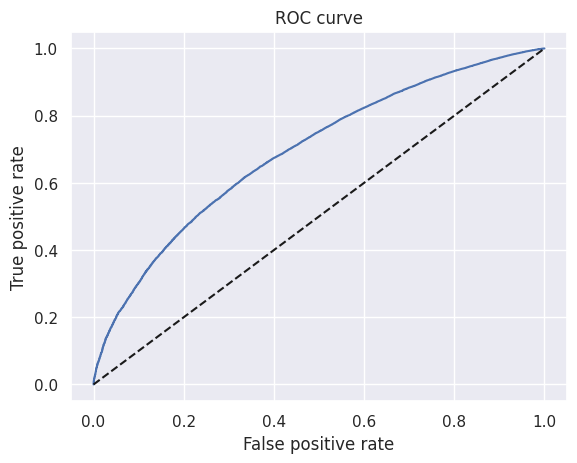

In [ ]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [ ]:
thresholds

array([       inf, 0.99100321, 0.98843279, ..., 0.52712855, 0.51330247,
       0.49992531])

In [ ]:
thresholds.shape

(18824,)

In [ ]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# Wir verketten 3 Datenrahmen entlang der Spalten.

In [ ]:
df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# Wir benennen die Spalten des Datenrahmens „Schwellenwerte“, „fpr“ und „tpr“.

In [ ]:
df_cutoffs.head()

,thresholds,fpr,tpr
0,inf,0.00000,0.000000
1,0.991003,0.00000,0.000012
2,0.988433,0.00000,0.000122
3,0.988352,0.00009,0.000122
4,0.984859,0.00009,0.001679


In [ ]:
df_cutoffs.loc[0,'thresholds'] = 1 - 1 / np.power(10, 16)
# Der erste Schwellenwert (der Wert der Schwellenwertspalte mit Index 0) sei gleich einer Zahl, die sehr nahe bei 1 liegt,
# aber kleiner als 1 ist, beispielsweise 1 - 1 / 10 ^ 16.

In [ ]:
df_cutoffs.head(5)

,thresholds,fpr,tpr
0,1.000000,0.00000,0.000000
1,0.991003,0.00000,0.000012
2,0.988433,0.00000,0.000122
3,0.988352,0.00009,0.000122
4,0.984859,0.00009,0.001679


### 2.Berechnung des Score-Werts zu jedem Threshold

Wir möchten jeden Schwellenwert (Threshold) des Modells – also eine Wahrscheinlichkeit $P(\text{gut})$ – in einen Scorewert auf unserer Skala (300–850) umwandeln.

Dazu verwenden wir folgende Formel:

$$
\text{Score} = \left(
\ln\left(\frac{p}{1 - p}\right) - \text{min_sum_coef}
\right)
\times
\frac{(\text{max_score} - \text{min_score})}{(\text{max_sum_coef} - \text{min_sum_coef})}
+ \text{min_score}
$$



**Schritt-für-Schritt-Erklärung:**

1. **Logit-Berechnung:**  
   Wandelt die Modellwahrscheinlichkeit $(p)  in Log-Odds-um  
   → ( ln(\frac{p}{1-p}))$.

2. **Zentrierung:**  
   Subtrahiere `min_sum_coef`, um den niedrigsten Punkt auf 0 zu setzen.

3. **Skalierung:**  
   Multipliziere mit der Rate, die den Koeffizientenbereich auf den Scorebereich (300–850) abbildet.

4. **Verschiebung:**  
   Addiere `min_score` (= 300), damit die Skala bei 300 beginnt.

Beispiel:
Wenn $( p = 0.8 )$, dann ist  
$[
\ln\left(\frac{0.8}{0.2}\right) = 1.386,
]$



und daraus ergibt sich ein Score von ungefähr **700 Punkten**.



In [ ]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# Die jedem Schwellenwert entsprechende Punktzahl entspricht:
# der Differenz zwischen dem natürlichen Logarithmus des Verhältnisses zwischen Schwellenwert und 1 minus Schwellenwert und
# der minimalen Summe der Koeffizienten
# multipliziert mit
# der Summe der minimalen Punktzahl und dem Verhältnis der Differenz zwischen maximaler und minimaler Punktzahl und
# der Differenz zwischen maximaler und minimaler Summe der Koeffizienten.

In [ ]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.00000,0.000000,3581.0
1,0.991003,0.00000,0.000012,788.0
2,0.988433,0.00000,0.000122,766.0
3,0.988352,0.00009,0.000122,766.0
4,0.984859,0.00009,0.001679,743.0


In [ ]:
df_cutoffs.loc[0,'Score'] = max_score

In [ ]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.000000,0.00000,0.000000,850.0
1,0.991003,0.00000,0.000012,788.0
2,0.988433,0.00000,0.000122,766.0
3,0.988352,0.00009,0.000122,766.0
4,0.984859,0.00009,0.001679,743.0


**Diese Funktion hilft uns, zu simulieren, wie viele Kunden wir genehmigen würden, wenn wir den Schwellenwert (Threshold) für „gut“ auf einen bestimmten Wert setzen (z. B. 0.8 oder 0.6).**

Schritt	Beschreibung:

- 1	Die Funktion n_approved(p) erhält einen Parameter p, der den Schwellenwert darstellt (z. B. 0.8).
- 2	Die Spalte y_hat_test_proba enthält die vom Modell vorhergesagte Wahrscheinlichkeit, dass ein Kunde „gut“ ist.
- 3	np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0) erstellt ein Array, in dem jede Zeile den Wert 1 erhält, wenn die Wahrscheinlichkeit ≥ p ist, sonst 0.
- 4	.sum() summiert alle 1-Werte und liefert die Gesamtanzahl der genehmigten Kunden.


$
n_{\text{approved}}(p) = \sum_{i=1}^{N}
\begin{cases}
1, & \text{wenn } \hat{y}_i \geq p \\
0, & \text{sonst}
\end{cases}
$
Dabei gilt:

$n_{\text{approved}}(p)$ = Anzahl genehmigter Kunden bei Schwellenwert $p$

$\hat{y}_i$ = vom Modell vorhergesagte Wahrscheinlichkeit für Kunde $i$

$N$ = Gesamtanzahl der Kunden

n_approved(0.8)
→ Gibt z. B. 540 zurück → das heißt, 540 Kunden hätten eine Wahrscheinlichkeit ≥ 0.8 und würden somit genehmigt.

In [ ]:
# Wir definieren eine Funktion namens „n_approved“, die den Wert 1 zuweist, wenn eine prognostizierte Wahrscheinlichkeit
# größer als der Parameter p (ein Schwellenwert) ist, und den Wert 0, wenn dies nicht der Fall ist.
# Anschließend wird die Spalte summiert.
# Bei Angabe von Prozentwerten gibt die Funktion daher
# die Anzahl der Zeilen zurück, deren geschätzte Wahrscheinlichkeiten größer als der Schwellenwert sind.
def n_approved(p):
    return np.where(df_actual_predicted_probs['y_hat_test_proba'] >= p, 1, 0).sum()

**Berechnung von Genehmigungs- und Ablehnungsraten für verschiedene
Schwellenwerte:**

<br/>

| Spalte           | Bedeutung                                                                                  |
| :--------------- | :----------------------------------------------------------------------------------------- |
| `N Approved`     | Wie viele Kunden **genehmigt** würden, wenn wir diesen Schwellenwert (z. B. 0.8) verwenden |
| `N Rejected`     | Wie viele Kunden **abgelehnt** würden                                                      |
| `Approval Rate`  | Anteil der **genehmigten Kunden** an allen Kunden                                          |
| `Rejection Rate` | Anteil der **abgelehnten Kunden** an allen Kunden


                          
<br/>


$
N_{\text{approved}}(t) = \sum_{i=1}^{N}
\begin{cases}
1, & \text{wenn } \hat{y}_i \geq t \\
0, & \text{sonst}
\end{cases}
$

$
N_{\text{rejected}}(t) = N - N_{\text{approved}}(t)
$

$
\text{Approval Rate}(t) = \frac{N_{\text{approved}}(t)}{N}
$

$
\text{Rejection Rate}(t) = 1 - \text{Approval Rate}(t)
$

<br/>

➡️ Wenn du den Threshold erhöhst, wirst du weniger Kredite genehmigen, aber bessere Kunden auswählen (niedrigere Ausfallrate).

➡️ Wenn du ihn senkst, genehmigst du mehr Kredite, riskierst aber mehr Ausfälle.


In [ ]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Unter der Annahme, dass alle Kreditanträge über einer bestimmten Wahrscheinlichkeit, „gut“ zu sein, genehmigt werden,
# wird bei Anwendung der Funktion „n_approved“ auf einen Schwellenwert die Anzahl der genehmigten Anträge zurückgegeben.
# Daher berechnen wir hier die Anzahl der genehmigten Anträge für alle Schwellenwerte.
df_cutoffs['N Rejected'] = df_actual_predicted_probs['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Anschließend berechnen wir die Anzahl der abgelehnten Anträge für jeden Schwellenwert.
# Dies ist die Differenz zwischen der Gesamtzahl der Anträge und der Anzahl der genehmigten Anträge für diesen Schwellenwert.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / df_actual_predicted_probs['y_hat_test_proba'].shape[0]
# Die Genehmigungsrate entspricht dem Verhältnis der genehmigten Anträge zu allen Anträgen.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Ablehnungsrate ist gleich eins minus Genehmigungsrate.

In [ ]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.000000,0.00000,0.000000,850.0,0,93257,0.000000,1.000000
1,0.991003,0.00000,0.000012,788.0,1,93256,0.000011,0.999989
2,0.988433,0.00000,0.000122,766.0,10,93247,0.000107,0.999893
3,0.988352,0.00009,0.000122,766.0,11,93246,0.000118,0.999882
4,0.984859,0.00009,0.001679,743.0,139,93118,0.001491,0.998509


In [ ]:
df_cutoffs.iloc[5000: 6200, ].head()
# Hier zeigen wir den Datenrahmen mit Cutoffs von Zeile mit Index 5000 bis Zeile mit Index 6200 an.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
5000,0.899604,0.238828,0.512244,570.0,44748,48509,0.479835,0.520165
5001,0.899576,0.238828,0.512390,570.0,44760,48497,0.479964,0.520036
5002,0.899576,0.238918,0.512390,570.0,44761,48496,0.479975,0.520025
5003,0.899573,0.238918,0.512402,570.0,44762,48495,0.479985,0.520015
5004,0.899570,0.239099,0.512402,570.0,44764,48493,0.480007,0.519993


In [ ]:
df_cutoffs.iloc[1000: 2000, ].head()
# Hier zeigen wir den Datenrahmen mit Cutoffs von Zeile mit Index 5000 bis Zeile mit Index 6200 an.

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
1000,0.950352,0.045052,0.185857,636.0,15776,77481,0.169167,0.830833
1001,0.950328,0.045052,0.186027,636.0,15790,77467,0.169317,0.830683
1002,0.950328,0.045142,0.186027,636.0,15791,77466,0.169328,0.830672
1003,0.950285,0.045142,0.186295,636.0,15813,77444,0.169564,0.830436
1004,0.950284,0.045232,0.186295,636.0,15814,77443,0.169574,0.830426


In [ ]:
#inputs_train_with_ref_cat.to_csv('inputs_train_with_ref_cat.csv')

In [ ]:
#df_scorecard.to_csv('df_scorecard.csv')